In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from statsmodels.tsa.stattools import acf, ccf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics import utils
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
import pandas as pd
from statsmodels.graphics.api import qqplot
import os
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

In [55]:
dir_path = "C:\\Users\\weber\\Documents\\Project-1018"
data = pd.read_csv(os.path.join(dir_path,'importdata','load_spp_eia_Jun19_Oct22.csv'))

In [56]:
data.columns = data.columns.str.replace(' ','')

In [57]:
data.head()

,Unnamed:0,UTCtime,Localdate,Hour,Localtime,Timezone,D,CSWS,SPRM,EDE,...,KCPL,LES,NPPD,OKGE,OPPD,SPS,SECI,WR,WAUE,WFEC
0,34824,2019-06-21 06:00:00,2019-06-21,1,2019-06-21 01:00:00,Central,31379.0,6147.0,386.0,586.0,...,1938.0,372.0,1553.0,4518.0,1320.0,3893.0,687.0,3830.0,2814.0,1158.0
1,34825,2019-06-21 07:00:00,2019-06-21,2,2019-06-21 02:00:00,Central,29906.0,5860.0,360.0,552.0,...,1805.0,346.0,1484.0,4318.0,1247.0,3736.0,654.0,3648.0,2728.0,1108.0
2,34826,2019-06-21 08:00:00,2019-06-21,3,2019-06-21 03:00:00,Central,28954.0,5654.0,347.0,532.0,...,1716.0,330.0,1431.0,4185.0,1209.0,3614.0,633.0,3518.0,2696.0,1098.0
3,34827,2019-06-21 09:00:00,2019-06-21,4,2019-06-21 04:00:00,Central,28332.0,5536.0,338.0,524.0,...,1668.0,318.0,1395.0,4063.0,1190.0,3551.0,614.0,3437.0,2665.0,1080.0
4,34828,2019-06-21 10:00:00,2019-06-21,5,2019-06-21 05:00:00,Central,28189.0,5490.0,341.0,526.0,...,1663.0,305.0,1395.0,4050.0,1187.0,3510.0,607.0,3424.0,2663.0,1072.0


In [58]:
# Use PCA that explain about 97% Variance
pca = PCA(n_components=0.97)
principalComponents = pca.fit_transform(data.loc[:,data.columns[6:]])
principalDf = pd.DataFrame(data = principalComponents)

In [59]:
pca.explained_variance_ratio_

array([0.98477517])

In [60]:
principalDf

,0
0,428.522574
1,-1117.788917
2,-2123.826679
3,-2780.318710
4,-2933.235273
...,...
29107,-499.454134
29108,-1453.036872
29109,-2556.696854
29110,-3848.788065


In [64]:
# principalDf.isnull().any()

False

### Sarima
Only Used a very small sample to train since it takes too long

In [68]:
# Sarima
import time
start_time = time.time()
principalDf = np.squeeze(principalDf)
idx = int(0.8*principalDf.shape[0])
train = principalDf[:idx]
test = principalDf[idx:]
auto_arima = pm.auto_arima(train, stepwise=False, seasonal=True)
auto_arima
print("--- %s seconds ---" % (time.time() - start_time))

--- 351.9991419315338 seconds ---


In [69]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                23289
Model:               SARIMAX(3, 1, 2)   Log Likelihood             -176605.551
Date:                Mon, 05 Dec 2022   AIC                         353225.101
Time:                        18:55:49   BIC                         353281.491
Sample:                             0   HQIC                        353243.415
                              - 23289                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2497      0.126      1.985      0.047       0.003       0.496
ar.L1          2.5674      0.004    728.991      0.000       2.560       2.574
ar.L2         -2.2312      0.007   -329.860      0.000      -2.244      -2.218
ar.L3          0.6401      0.004    179.446      0.000       0.633       0.647
ma.L1         -1.9013      0.002   -898.498      0.000      -1.905      -1.897
ma.L2          0.9329      0.002    414.877      0.000       0.929       0.937
sigma2      2.658e+05    593.193    448.127      0.000    2.65e+05    2.67e+05
===================================================================================
Ljung-Box (L1) (Q):                 175.29   Jarque-Bera (JB):          20495524.81
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                            -0.60
Prob(H) (two-sided):                  0.00   Kurtosis:                       148.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

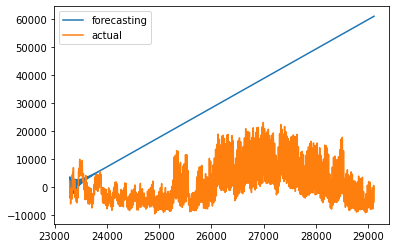

In [70]:
pred = auto_arima.predict(n_periods=len(test))
plt.plot(pred, label = "forecasting")
plt.legend()
plt.plot(test,label = "actual")
plt.legend()

In [71]:
rms = mean_squared_error(test, pred, squared=False)
rms

33333.11094706176

### Kalman Filter

In [73]:
from pykalman import KalmanFilter
kf = KalmanFilter(n_dim_state=1, n_dim_obs=1)
kf.em(principalDf, n_iter=6)
f_means, f_covariances = kf.filter(principalDf)
s_means, s_covariances = kf.smooth(principalDf)

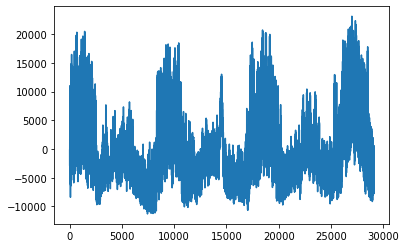

In [74]:
plt.plot(f_means)

In [75]:
vars(kf)

{'transition_matrices': array([[1.]]),
 'observation_matrices': array([[1.]]),
 'transition_covariance': array([[1388012.19063955]]),
 'observation_covariance': array([[67131.09731797]]),
 'transition_offsets': array([0.]),
 'observation_offsets': array([0.]),
 'initial_state_mean': array([-208.21555155]),
 'initial_state_covariance': array([[0.38195724]]),
 'random_state': None,
 'em_vars': ['transition_covariance',
  'observation_covariance',
  'initial_state_mean',
  'initial_state_covariance'],
 'n_dim_state': 1,
 'n_dim_obs': 1}

In [77]:
next_mean, next_covariance = kf.filter_update(
   f_means[-1], f_covariances[-1], train.iloc[-1]
)

In [78]:
idx = int(0.8*principalDf.shape[0])
f_means, f_covariances = kf.filter(principalDf[:idx])
pred = []
for i in range(idx,principalDf.shape[0]):
    next_mean, next_covariance = kf.filter_update(
    f_means[-1], f_covariances[-1], principalDf.iloc[i]
        )
    print(f_means[-1])
    print(principalDf.iloc[i])
    print(next_mean)
    # CC: bug was because np.append returns a copy, and does not append in-place
    f_means = np.append(f_means,[next_mean])

    f_covariances = np.append(f_covariances,[next_covariance])
    pred.append(f_means[-1])

[2704.90071472]
2055.262311751682
[2083.96678363]
2083.966783633213
939.5490740300368
[[990.11552117]]
990.1155211736257
43.37008494712561
[[85.20232213]]
85.20232212561302
-779.6540640791501
[[-741.44011967]]
-741.4401196663335
-1549.2802273034495
[[-1513.58556463]]
-1513.5855646286923
-2009.9618788839773
[[-1988.02933935]]
-1988.0293393509926
-2439.6500655916434
[[-2419.69506543]]
-2419.6950654280095
-2679.2195093908026
[[-2667.75234232]]
-2667.7523423171087
-2553.4850337988714
[[-2558.53396984]]
-2558.5339698367725
-2184.362248692943
[[-2200.89514084]]
-2200.8951408363246
-1056.2048885988643
[[-1106.78337812]]
-1106.783378122255
-952.5963351856433
[[-959.40913692]]
-959.4091369200589
-1411.8526504650526
[[-1391.86129519]]
-1391.8612951922776
-2326.5547578665028
[[-2285.25504083]]
-2285.2550408320967
-3564.634856970861
[[-3508.1050678]]
-3508.1050677981757
-4593.525179639114
[[-4545.56555943]]
-4545.565559429266
-5311.04319657251
[[-5277.22033264]]
-5277.220332636208
-5769.0597992878

In [79]:
test = principalDf[idx:]
np.array(pred).shape

(5823,)

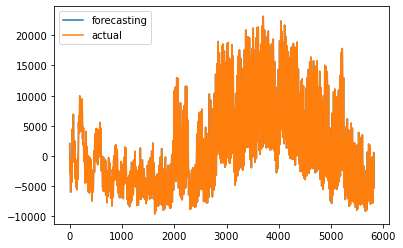

In [80]:
test = principalDf[idx:].reset_index(drop = True)
plt.plot(pred, label = "forecasting")
plt.legend()
plt.plot(test,label = "actual")
plt.legend()